# Similarity Measures for Fish Welfare Criteria
### Initial Hypotheses
Certain pairs of criteria will have a higher potential of being jointly met, be that because farms that meet this criteria, generally also meet the other criteria, or because criteria are inter-related somehow. For example, we might imagine stress and aggression to be positively correlated as we expect stress to exacerbate aggression, and we might expect home range and aggression to be correlated as fish in confined spaces may become more aggressive.

* [_An ordinal attribute is an attribute whose possible values have a meaningful order or ranking among them, but the magnitude between successive values is not known._](https://www.raynergobran.com/2016/02/distance-observations-numeric-ordinal/)
* [Distance for ordinal measures](https://people.revoledu.com/kardi/tutorial/Similarity/OrdinalVariables.html)

### Criteria (explanations to be added later)
| Id | Criterion      | Description |
| --- | ----------- | ----------- |
| 17 | Home range      |        |
| 18 | Depth range   |         |
| 29 | Migration   |         |
| 30 | Reproduction   |         |
| 31 | Aggregation   |         |
| 32 | Aggression   |         |
| 33 | Substrate   |         |
| 34 | Stress   |         |
| 35 | Malformation   |         |
| 36 | Slaughter   |         |


In [85]:
from os.path import exists, join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def make_multilevel(likelihood, potential):
    """Combine Likelihood and Potential into a multilevel dataframe."""
    likelihood_t = likelihood.transpose()
    likelihood_t['level'] = ['likelihood'] * 10

    potential_t = potential.transpose()
    potential_t['level'] = ['potential'] * 10
    
    both = pd.concat([likelihood_t, potential_t])
    both = both.groupby(['Criterion', 'level']).agg(lambda x: x)
    both = both.transpose()
    
    return both

def make_heatmap(df, row1, row2, possible_values, **kwargs):
    """Make a heatmap for value counts of each ranking. 
    
    Clearer than scatter plots for ordinal data.
    Colours indicate frequency a value is recorded."""
    
    n = len(possible_values)
    pv_dict = {index: value for index, value in zip(range(n), possible_values)}
    pv_dict_r = {value: key for key, value in pv_dict.items()}
    
    value_counts = np.zeros((n, n))
    
    for ix, row in df[[row1, row2]].iterrows():
        if (not np.isnan(row[row1])) and (not np.isnan(row[row2])):
            
            idx1 = pv_dict_r[int(row[row1])]
            idx2 = pv_dict_r[int(row[row2])]
            value_counts[idx1, idx2] += 1
        
    return value_counts, pv_dict

def plot_heatmap(measure, col1, col2, values, ax, title, lims=[0, 20], cbar=True):
    heatmap, pv_dict = make_heatmap(measure, criteria_dict_r[col1], criteria_dict_r[col2], values)
    im = ax.imshow(heatmap, vmin=lims[0], vmax=lims[1])
    ax.set_xlabel(col1)
    ax.set_ylabel(col2)
    ax.set_xticks([*pv_dict.keys()])
    ax.set_yticks([*pv_dict.keys()])
    ax.set_xticklabels([*pv_dict.values()])
    ax.set_yticklabels([*pv_dict.values()])
    ax.invert_yaxis()
    ax.set_title(f'Heatmap of value-pairs\nfor {title}')
    if cbar:
        plt.colorbar(im);
    return im

wd = join('..', '..', 'data')

## Load and initial look at data

In [86]:
df = pd.read_csv(join(wd, 'feb_farm_data_s2.csv'))

# get criterion dictionary
criteria_df = df.head(10)[['Criterion.1', 'Unnamed: 7']].set_index('Criterion.1')
criteria_df.index.name = 'index'
criteria_df.columns = ['criterion']
criteria_dict = {int(val): name for val, name in zip(criteria_df.index, criteria_df['criterion'])}
criteria_dict_r = {value: key for key, value in criteria_dict.items()}

# set up dataframe for each of likelihood, potential, and uncertainty
likelihood = df.pivot(index="Fish ID", columns="Criterion", values="Likelihood")
potential = df.pivot(index="Fish ID", columns="Criterion", values="Potential")
certainty = df.pivot(index="Fish ID", columns="Criterion", values="Certainty")

# combine into one multiindex df (useful for operations later)
df_all = make_multilevel(likelihood, potential)

In [87]:
# Check unique values (<0 should be removed)
print(set(likelihood.values.ravel()))
print(set(potential.values.ravel()))

{0, 2, -1, -2}
{0, 1, 2, -2, -1}


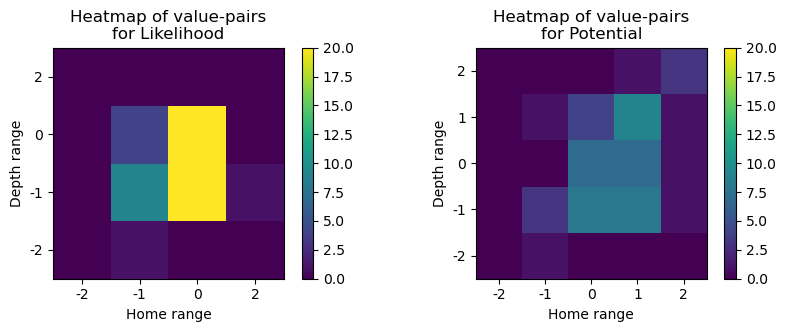

In [88]:
# inspect a single pair of criteria for Potential and Likelihood
i = 'Home range'
j = 'Depth range'

# plot
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

plot_heatmap(likelihood, i, j, [-2, -1, 0, 2], axs[0], 'Likelihood')
plot_heatmap(potential, i, j, [-2, -1, 0, 1, 2], axs[1], 'Potential')

In [89]:
# make a multilevel dataframe and remove negative values
idx = pd.IndexSlice
both = make_multilevel(likelihood, potential)
both = both.applymap(lambda x: np.nan if x < 0 else x)
likelihood = both.loc[:, idx[:, 'likelihood']].droplevel('level', axis=1)
potential = both.loc[:, idx[:, 'potential']].droplevel('level', axis=1)

# get normalised rank transformations (to use with quantitative distance measures such as Euclidean)
likelihood_z = (likelihood / 2) / (2 - 1)
potential_z = (potential) / (3 - 1)

In [90]:
# look at data now, all negatives are replaces by NaNs
likelihood.head()

Criterion,17,18,29,30,31,32,33,34,35,36
Fish ID,,,,,,,,,,
1,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,2.0
2,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0
3,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN
4,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,0.0,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN


In [91]:
# look at what unique values exist in dataframe
print(set(pd.unique(likelihood.values.ravel('K'))))
print(set(pd.unique(potential.values.ravel('K'))))

{0.0, 2.0, nan}
{0.0, 1.0, 2.0, nan}


In [92]:
# look at what unique values exist in dataframe
print(set(pd.unique(likelihood_z.values.ravel('K'))))
print(set(pd.unique(potential_z.values.ravel('K'))))

{0.0, 1.0, nan}
{0.5, 0.0, 1.0, nan}


# Measures in one dimension
## Euclidean Distance

$$ d(\mathbf{u}, \mathbf{v}) = \sqrt{\sum_{i=1}^n \left(u_i - v_i \right)^2} $$

In [93]:
i = 'Home range'
j = 'Depth range'
col1 = criteria_dict_r[i]
col2 = criteria_dict_r[j]

m = "Substrate"
n = "Slaughter"
col3 = criteria_dict_r[m]
col4 = criteria_dict_r[n]

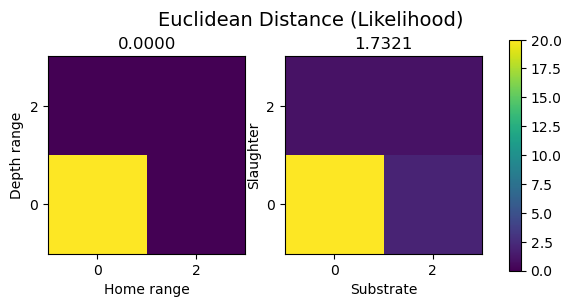

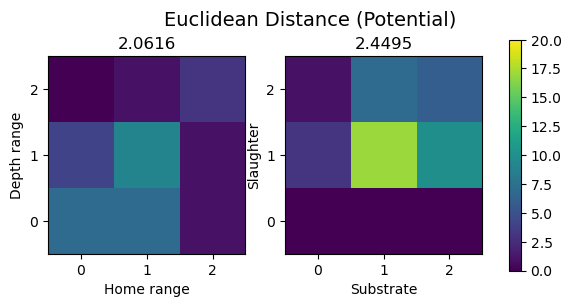

In [105]:
# look at example results
def euclidean_dist(df, col1, col2):
    """Requires normalised data."""
    return np.sqrt(((df[col1] - df[col2]) ** 2).sum(skipna=True))

fig, axs = plt.subplots(1, 2, figsize=(7, 3))
im = plot_heatmap(likelihood, i, j, [0, 2], axs[0], 'Likelihood', cbar=False)
plot_heatmap(likelihood, m, n, [0, 2], axs[1], 'Likelihood', cbar=False)
axs[0].set_title(f"{euclidean_dist(likelihood_z, col1, col2):.4f}");
axs[1].set_title(f"{euclidean_dist(likelihood_z, col3, col4):.4f}");
fig.colorbar(im, ax=axs.ravel().tolist())
plt.suptitle("Euclidean Distance (Likelihood)", fontsize=14);


fig, axs = plt.subplots(1, 2, figsize=(7, 3))
im = plot_heatmap(potential, i, j, [0, 1, 2], axs[0], 'Likelihood', cbar=False)
plot_heatmap(potential, m, n, [0, 1, 2], axs[1], 'Likelihood', cbar=False)
axs[0].set_title(f"{euclidean_dist(potential_z, col1, col2):.4f}");
axs[1].set_title(f"{euclidean_dist(potential_z, col3, col4):.4f}");
fig.colorbar(im, ax=axs.ravel().tolist())
plt.suptitle("Euclidean Distance (Potential)", fontsize=14);

## Cosine Similarity

$$ S_c(\mathbf{u}, \mathbf{v}) = \cos(\theta) = \frac{\mathbf{u} \cdot \mathbf{v}}{||\mathbf{u}||\cdot||\mathbf{v}||} = \frac{\sum_i^n u_iv_i}{\sqrt{\sum_i^n u_i^2}\sqrt{\sum_i^n v_i^2}} $$

Can't calculate cosine similarity for zero vector. Returning NaN.



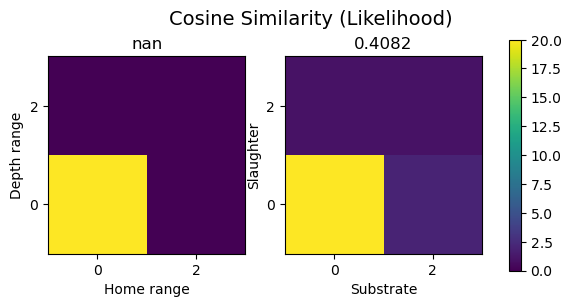

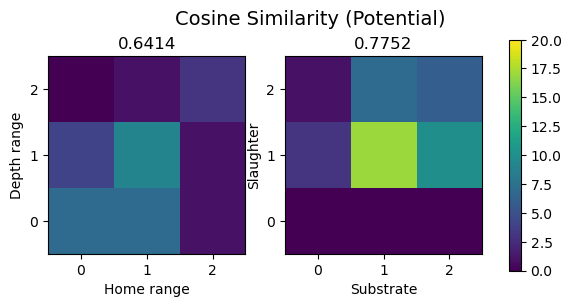

In [111]:
def cosine_similarity(df, col1, col2):
    """Requires normalised data"""
    if (df[col1].sum() == 0) or (df[col2].sum() == 0):
        print("Can't calculate cosine similarity for zero vector. Returning NaN.\n")
        return np.nan
    return (df[col1] * df[col2]).sum() / ( np.sqrt((df[col1] ** 2).sum()) * np.sqrt((df[col2] ** 2).sum()))


# look at example results
fig, axs = plt.subplots(1, 2, figsize=(7, 3))
im = plot_heatmap(likelihood, i, j, [0, 2], axs[0], 'Likelihood', cbar=False)
plot_heatmap(likelihood, m, n, [0, 2], axs[1], 'Likelihood', cbar=False)
axs[0].set_title(f"{cosine_similarity(likelihood, col1, col2):.4f}");
axs[1].set_title(f"{cosine_similarity(likelihood, col3, col4):.4f}");
fig.colorbar(im, ax=axs.ravel().tolist())
plt.suptitle("Cosine Similarity (Likelihood)", fontsize=14);


fig, axs = plt.subplots(1, 2, figsize=(7, 3))
im = plot_heatmap(potential, i, j, [0, 1, 2], axs[0], 'Likelihood', cbar=False)
plot_heatmap(potential, m, n, [0, 1, 2], axs[1], 'Likelihood', cbar=False)
axs[0].set_title(f"{cosine_similarity(potential, col1, col2):.4f}");
axs[1].set_title(f"{cosine_similarity(potential, col3, col4):.4f}");
fig.colorbar(im, ax=axs.ravel().tolist())
plt.suptitle("Cosine Similarity (Potential)", fontsize=14);

## Plots

In [112]:
def cosine_similarity(col1, col2):
    if (col1.sum() == 0) or (col2.sum() == 0):
        return np.nan
    return (col1 * col2).sum() / ( np.sqrt((col1 ** 2).sum()) * np.sqrt((col2 ** 2).sum()))

def euclidean_similarity(col1, col2):
    """Requires normalised data. Not bounded."""
    
    euclidean_dist = np.sqrt(((col1 - col2) ** 2).sum())
    return 1 / (1 + euclidean_dist)

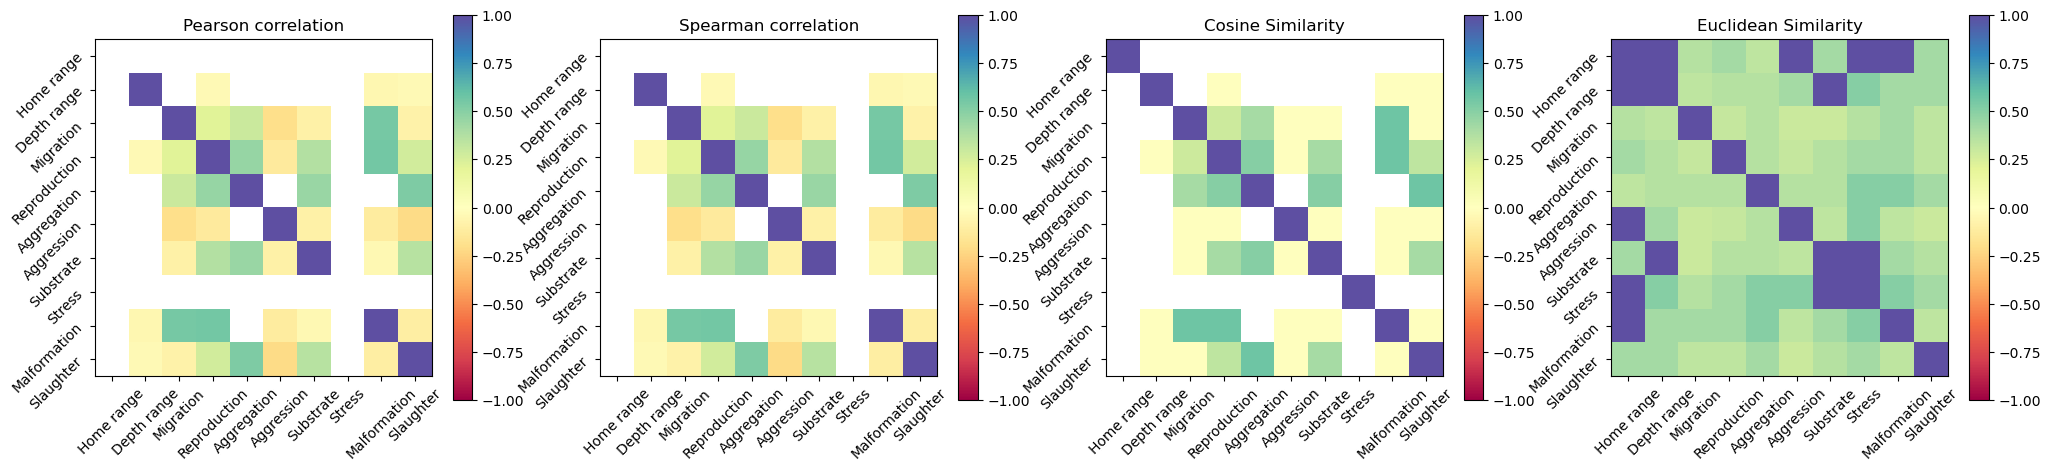

In [113]:
# plot correlation coefficients
pearson_likelihood = likelihood.corr(method='pearson')
spearman_likelihood = likelihood.corr(method='spearman')
cosine_likelihood = likelihood.corr(method=cosine_similarity)
euclidean_likelihood = likelihood_z.corr(method=euclidean_similarity)

fig, axs = plt.subplots(1, 4, figsize=(25, 5))

ax = axs[0]
im = ax.imshow(pearson_likelihood.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Pearson correlation')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
plt.colorbar(im, ax=ax);

ax = axs[1]
im = ax.imshow(spearman_likelihood.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Spearman correlation')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
plt.colorbar(im, ax=ax);

ax = axs[2]
im = ax.imshow(cosine_likelihood.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Cosine Similarity')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
plt.colorbar(im, ax=ax);

ax = axs[3]
im = ax.imshow(euclidean_likelihood.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Euclidean Similarity')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
plt.colorbar(im, ax=ax);

fig.savefig(join('..', 'images', 'likelihood.png'))

Note the high Euclidean similarity values for, e.g., Home Range and Depth Range, are accurate but misleading. There are only a few non-NaN values in the data, and these are all zeros. There needs to be a way to account for NaNs here, so that sparse data does not appear as correlated as non-sparse data. Also, certainty is not factored in yet.

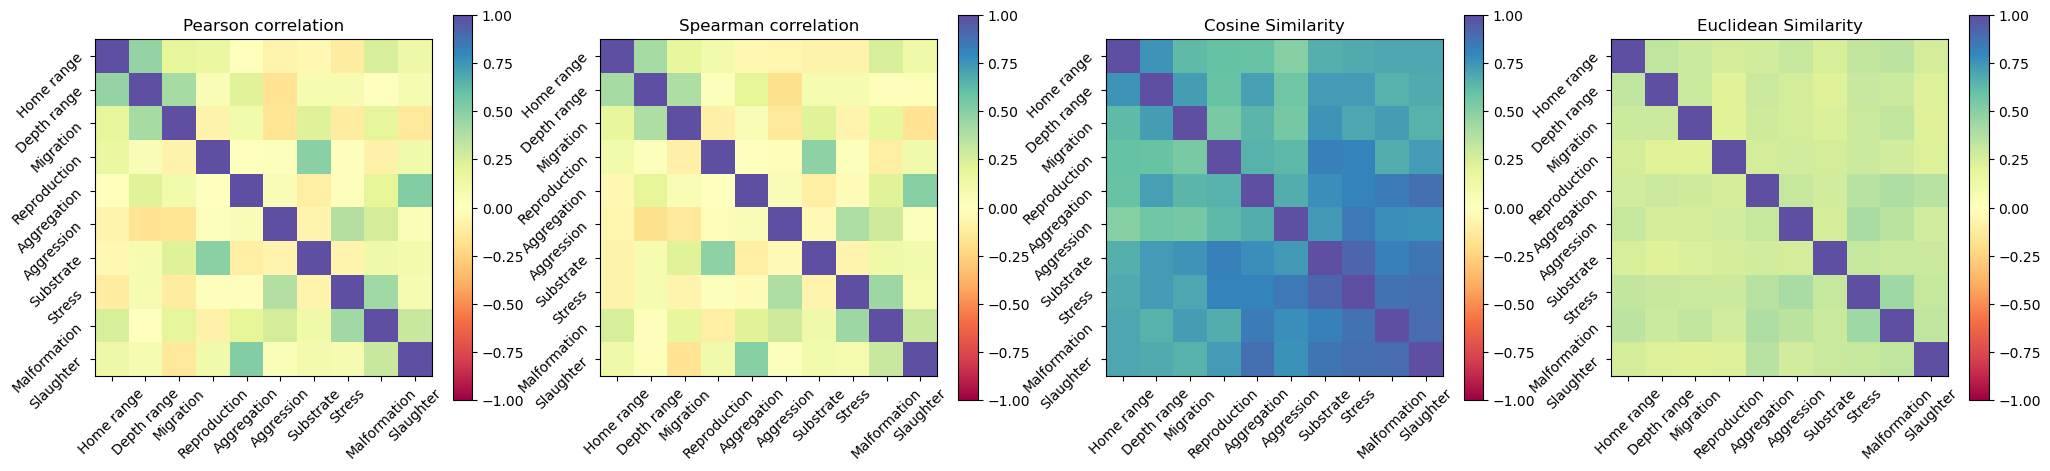

In [114]:
# plot correlation coefficients for potential
pearson_potential = potential.corr(method='pearson')
spearman_potential = potential.corr(method='spearman')
cosine_potential = potential.corr(method=cosine_similarity)
euclidean_potential = potential_z.corr(method=euclidean_similarity)

fig, axs = plt.subplots(1, 4, figsize=(25, 5))

ax = axs[0]
im = ax.imshow(pearson_potential.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Pearson correlation')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
plt.colorbar(im, ax=ax);

ax = axs[1]
im = ax.imshow(spearman_potential.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Spearman correlation')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
plt.colorbar(im, ax=ax);

ax = axs[2]
im = ax.imshow(cosine_potential.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Cosine Similarity')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
plt.colorbar(im, ax=ax);

ax = axs[3]
im = ax.imshow(euclidean_potential.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Euclidean Similarity')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
plt.colorbar(im, ax=ax);

fig.savefig(join('..', 'images', 'potential.png'))

# Dealing with NaN data
Later...

# Isolating different fish families
Later...

# Sampling data 
**Certainty values:** -2 (no findings), 0 (low), 1 (medium), 2 (high). <br>
**Idea:** Re-sample data according to certainty values.
$$ \mathbb{P}_{\text{high}}(a, b, c | a) = (0.99, 0.05, 0.05) $$
$$ \mathbb{P}_{\text{medium}}(a, b, c | a) = (0.90, 0.5, 0.5) $$
$$ \mathbb{P}_{\text{low}}(a, b, c | a) = (0.5, 0.25, 0.25) $$

In [32]:
certainty_probs = {0: (0.005, 0.99), 
                   1: (0.05, 0.9),
                   2: (0.25, 0.5)}

def probabilities(score, possible_scores, certainty):
    high = certainty_probs[certainty][1]
    low = certainty_probs[certainty][0]
    probabilities = [high if pscore==score else low for pscore in possible_scores]
    return probabilities

def random_sample(measure, certainty):
    pass

potential_sample = {}
likelihood_sample = {}

In [98]:
n = 5

for criterion in [*criteria_dict.keys()]:
    sample = np.array([])
    possible_scores = [0, 1, 2]  # potential
    scores = [(score, cert) for score, cert in zip(potential[criterion], certainty[criterion])]
    for score in scores:
        if not np.isnan(score[0]):
            probabilities(score[0], [0, 1, 2], score[1])
            sample = np.append(sample, np.random.choice(possible_scores, n, p=probabilities(score[0], [0, 1, 2], score[1])))
        else:
            sample = np.append(sample, [np.nan] * n)

    potential_sample[criterion] = sample

potential_sample_df = pd.DataFrame.from_dict(potential_sample)
potential_sample_df_z = (potential_sample_df) / (3 - 1)


for criterion in [*criteria_dict.keys()]:
    sample = np.array([])
    possible_scores = [0, 1, 2]  # potential
    scores = [(score, cert) for score, cert in zip(likelihood[criterion], certainty[criterion])]
    for score in scores:
        if not np.isnan(score[0]):
            probabilities(score[0], [0, 1, 2], score[1])
            sample = np.append(sample, np.random.choice(possible_scores, n, p=probabilities(score[0], [0, 1, 2], score[1])))
        else:
            sample = np.append(sample, [np.nan] * n)

    likelihood_sample[criterion] = sample
    
likelihood_sample_df = pd.DataFrame.from_dict(likelihood_sample)
likelihood_sample_df_z = (likelihood_sample_df) / (2 - 1)

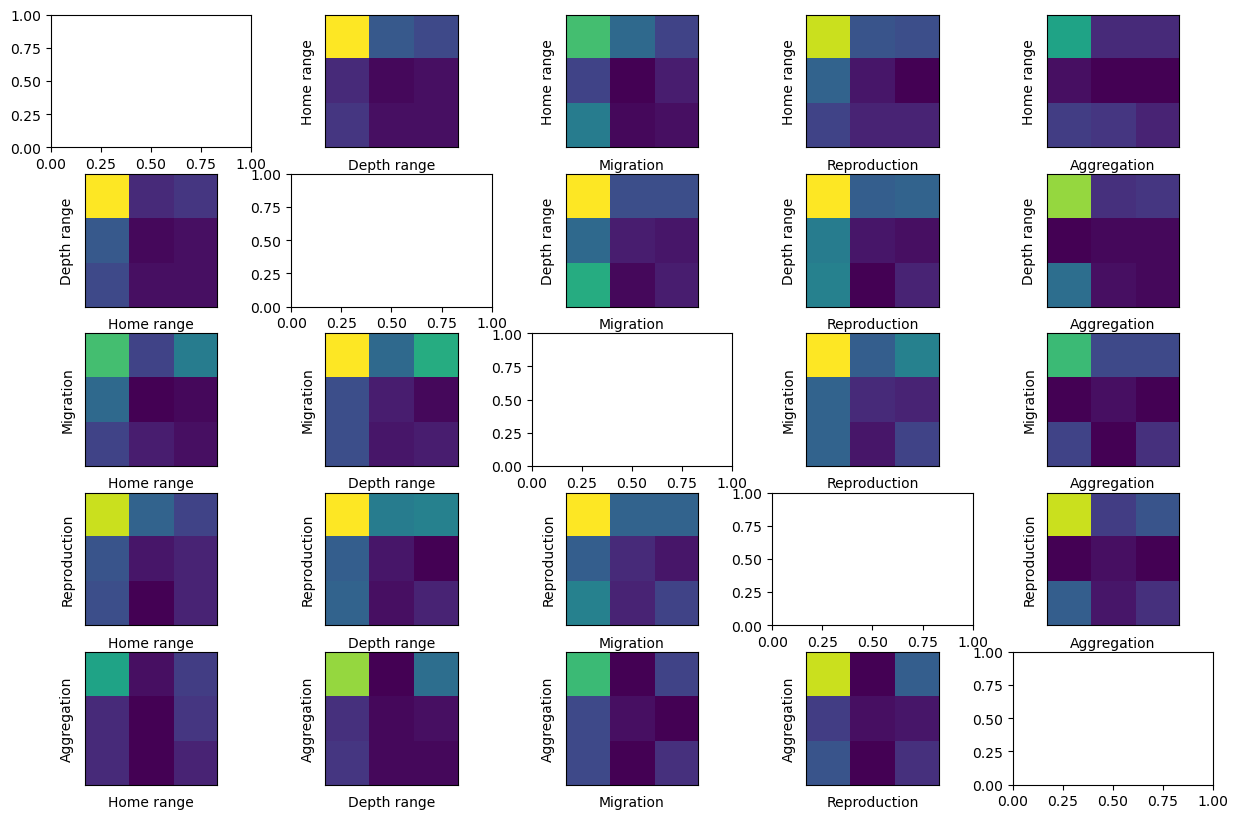

In [253]:
fig, axs = plt.subplots(5, 5, figsize=(15, 10))

for i in range(5):
    for j in range(5):
        if j != i:
            ax = axs[j, i]
            ix = [*criteria_dict.keys()][i]
            jx = [*criteria_dict.keys()][j]
            #print(f"{(ix, jx)}:")

            xlabel = [*criteria_dict.values()][i]
            ylabel = [*criteria_dict.values()][j]

            value_counts = make_heatmap(likelihood_sample_df, ix, jx)
            #print(f"min: {value_counts.min()}, max: {value_counts.max()}")
            ax.imshow(value_counts, vmin=0, vmax=50)

            # make_heatmap(likelihood_sample_df, ix, jx, ax=ax, vmin=2000, vmax=2500)
            #ax.scatter(likelihood_sample_df[ix], likelihood_sample_df[jx], alpha=0.03, s=100)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_xticklabels([])
            ax.set_yticklabels([])

            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
        

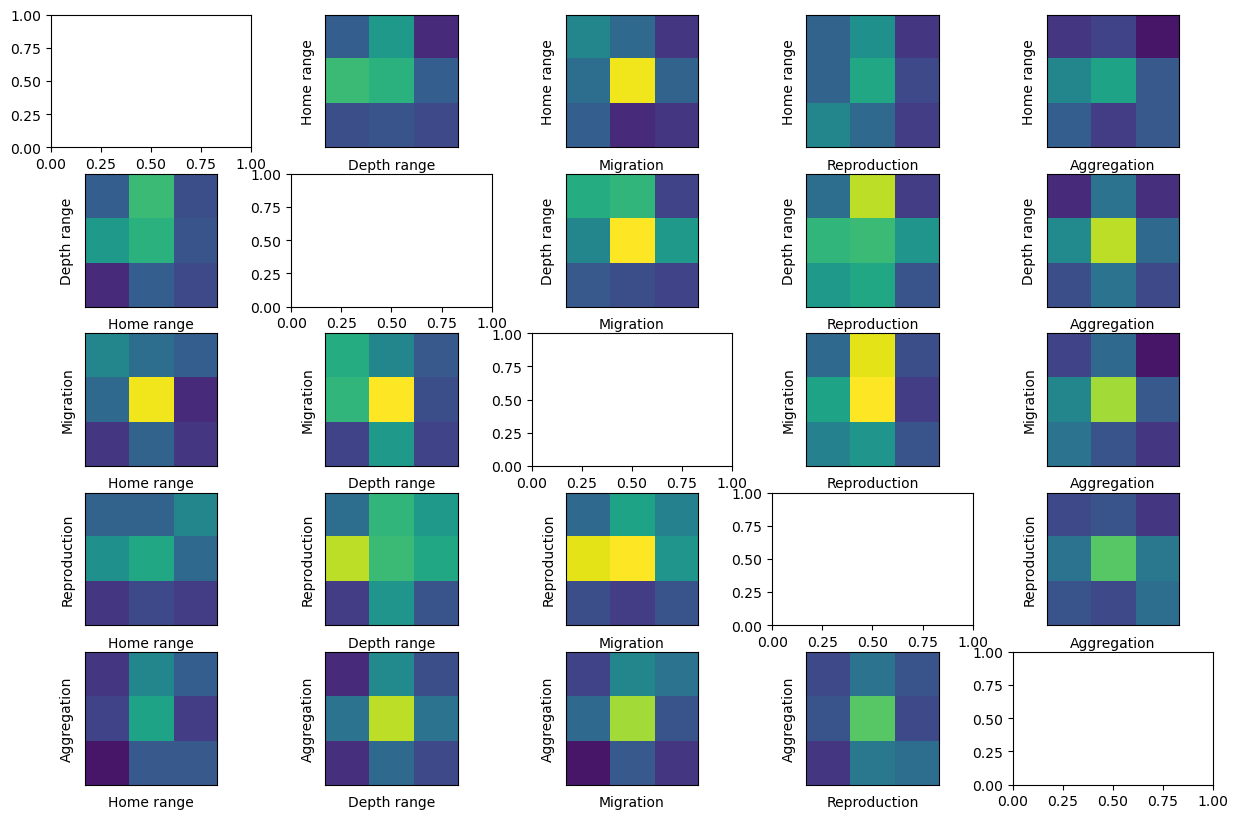

In [258]:
fig, axs = plt.subplots(5, 5, figsize=(15, 10))

for i in range(5):
    for j in range(5):
        if j != i:
            ax = axs[j, i]
            ix = [*criteria_dict.keys()][i]
            jx = [*criteria_dict.keys()][j]
            #print(f"{(ix, jx)}:")

            xlabel = [*criteria_dict.values()][i]
            ylabel = [*criteria_dict.values()][j]

            value_counts = make_heatmap(potential_sample_df, ix, jx)
            #print(f"min: {value_counts.min()}, max: {value_counts.max()}")
            ax.imshow(value_counts, vmin=0, vmax=50)

            #ax.scatter(potential_sample_df[ix], potential_sample_df[jx], alpha=0.03, s=100)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_xticklabels([])
            ax.set_yticklabels([])

            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)

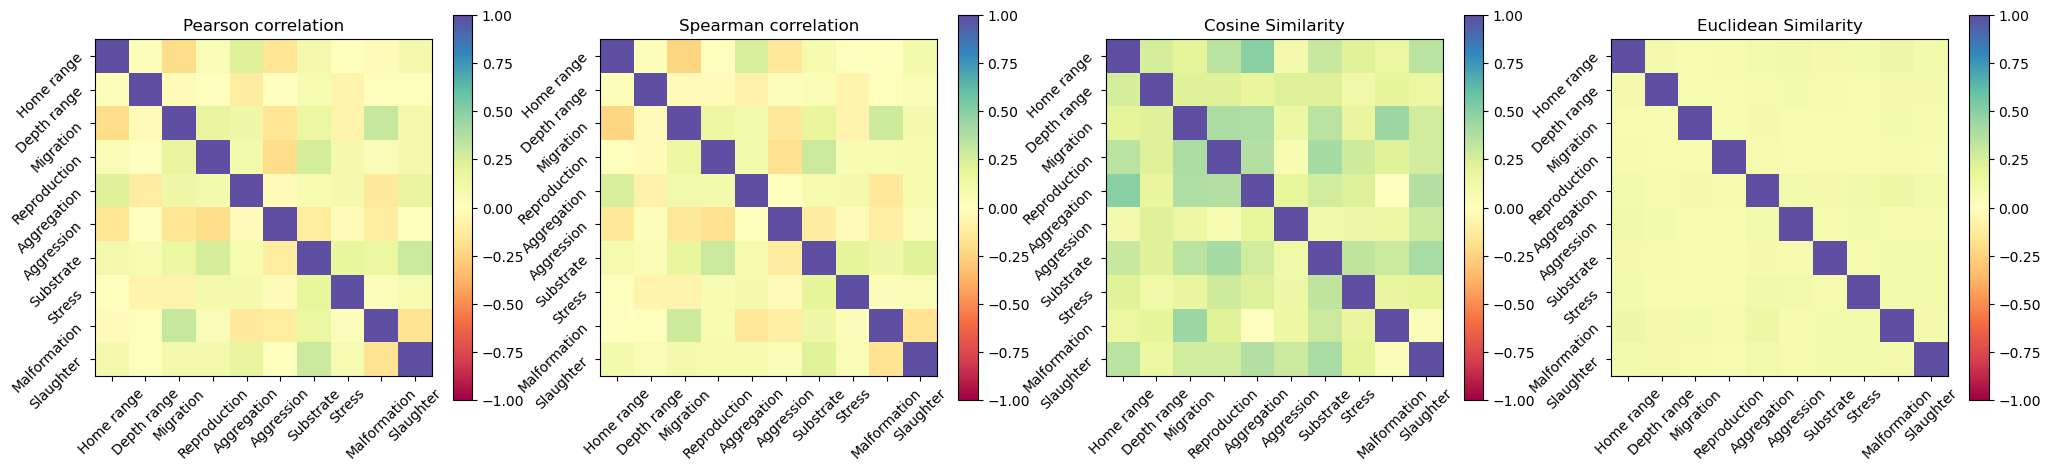

In [100]:
# plot correlation coefficients for likelihood
pearson_likelihood = likelihood_sample_df.corr(method='pearson')
spearman_likelihood = likelihood_sample_df.corr(method='spearman')
cosine_likelihood = likelihood_sample_df.corr(method=cosine_similarity)
euclidean_likelihood = likelihood_sample_df_z.corr(method=euclidean_similarity)

fig, axs = plt.subplots(1, 4, figsize=(25, 5))

ax = axs[0]
im = ax.imshow(pearson_likelihood.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Pearson correlation')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
plt.colorbar(im, ax=ax);

ax = axs[1]
im = ax.imshow(spearman_likelihood.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Spearman correlation')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
plt.colorbar(im, ax=ax);

ax = axs[2]
im = ax.imshow(cosine_likelihood.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Cosine Similarity')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
plt.colorbar(im, ax=ax);

ax = axs[3]
im = ax.imshow(euclidean_likelihood.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Euclidean Similarity')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
plt.colorbar(im, ax=ax);


fig.savefig(join('..', 'images', 'likelihood_resample.png'))

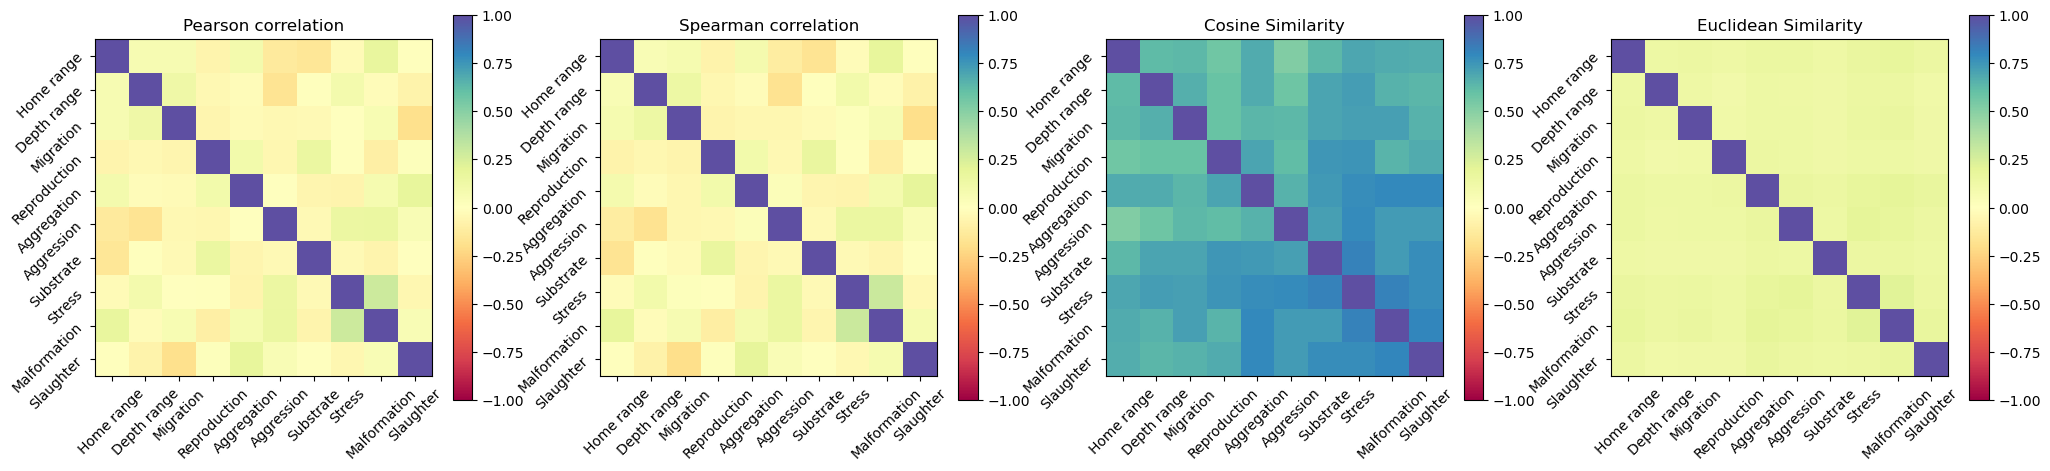

In [101]:
# plot correlation coefficients for potential
pearson_potential = potential_sample_df.corr(method='pearson')
spearman_potential = potential_sample_df.corr(method='spearman')
cosine_potential = potential_sample_df.corr(method=cosine_similarity)
euclidean_potential = potential_sample_df_z.corr(method=euclidean_similarity)

fig, axs = plt.subplots(1, 4, figsize=(25, 5))

ax = axs[0]
im = ax.imshow(pearson_potential.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Pearson correlation')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
plt.colorbar(im, ax=ax);

ax = axs[1]
im = ax.imshow(spearman_potential.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Spearman correlation')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
plt.colorbar(im, ax=ax);

ax = axs[2]
im = ax.imshow(cosine_potential.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Cosine Similarity')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
plt.colorbar(im, ax=ax);

ax = axs[3]
im = ax.imshow(euclidean_potential.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Euclidean Similarity')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
plt.colorbar(im, ax=ax);

fig.savefig(join('..', 'images', 'potential_resample.png'))

(array([ 8., 20., 18., 22.,  8., 14.,  0.,  0.,  0., 10.]),
 array([0.5621985 , 0.60597865, 0.6497588 , 0.69353895, 0.7373191 ,
        0.78109925, 0.8248794 , 0.86865955, 0.9124397 , 0.95621985,
        1.        ]),
 <BarContainer object of 10 artists>)

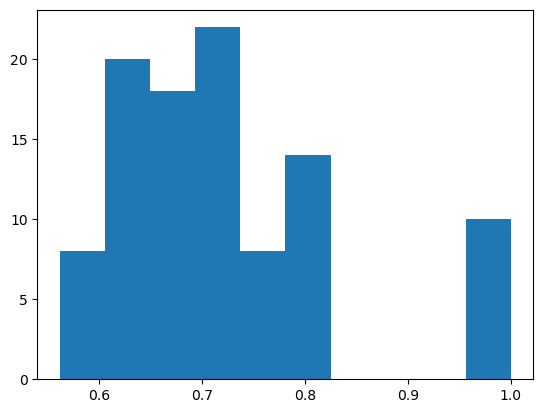

In [73]:
plt.hist(cosine_potential.to_numpy().ravel())

In [60]:
euclidean_potential

,17,18,29,30,31,32,33,34,35,36
17,1.000000,0.035211,0.033162,0.034325,0.038111,0.041933,0.032961,0.042294,0.044899,0.035133
18,0.035211,1.000000,0.030661,0.026891,0.036038,0.034850,0.028267,0.035762,0.036135,0.028833
29,0.033162,0.030661,1.000000,0.027397,0.035893,0.034267,0.030879,0.037398,0.040389,0.030178
30,0.034325,0.026891,0.027397,1.000000,0.034398,0.034563,0.027792,0.034552,0.034195,0.028647
31,0.038111,0.036038,0.035893,0.034398,1.000000,0.042443,0.035400,0.045917,0.052747,0.043948
32,0.041933,0.034850,0.034267,0.034563,0.042443,1.000000,0.033585,0.050637,0.043859,0.037063
33,0.032961,0.028267,0.030879,0.027792,0.035400,0.033585,1.000000,0.036007,0.037701,0.033590
34,0.042294,0.035762,0.037398,0.034552,0.045917,0.050637,0.036007,1.000000,0.051842,0.037778
35,0.044899,0.036135,0.040389,0.034195,0.052747,0.043859,0.037701,0.051842,1.000000,0.043532
36,0.035133,0.028833,0.030178,0.028647,0.043948,0.037063,0.033590,0.037778,0.043532,1.000000
